In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
DATA_PATH = "data/"

In [14]:
trades = pd.read_csv(DATA_PATH + "historical_data.csv")
sentiment = pd.read_csv(DATA_PATH + "fear_greed_index.csv")

In [15]:
trades["Timestamp"] = pd.to_datetime(trades["Timestamp"], unit="ms")
trades["date"] = trades["Timestamp"].dt.date
sentiment["date"] = pd.to_datetime(sentiment["date"]).dt.date

In [16]:
df = trades.merge(
    sentiment[["date", "classification", "value"]],
    on="date",
    how="inner"
)

# Market Sentiment vs Overall Trader Performance

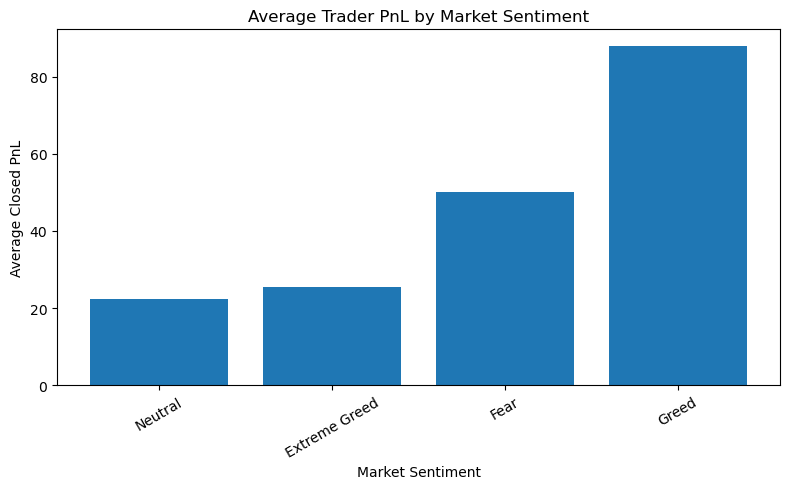

In [19]:
sentiment_pnl = (
    df.groupby("classification")["Closed PnL"]
    .mean()
    .sort_values()
)

plt.figure(figsize=(8,5))
plt.bar(sentiment_pnl.index, sentiment_pnl.values)
plt.title("Average Trader PnL by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Sentiment-Adjusted Trader

In [20]:
sentiment_baseline = (
    df.groupby("classification")["Closed PnL"]
    .mean()
    .to_dict()
)

df["sentiment_alpha"] = df.apply(
    lambda x: x["Closed PnL"] - sentiment_baseline.get(x["classification"], 0),
    axis=1
)

trader_alpha = (
    df.groupby("Account")["sentiment_alpha"]
    .sum()
    .reset_index()
    .sort_values("sentiment_alpha", ascending=False)
)


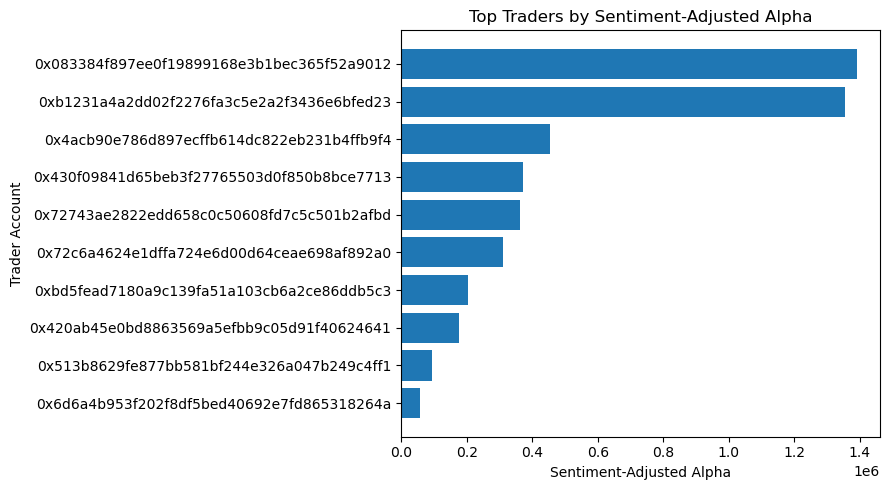

In [21]:
top_alpha = trader_alpha.head(10)

plt.figure(figsize=(9,5))
plt.barh(top_alpha["Account"], top_alpha["sentiment_alpha"])
plt.title("Top Traders by Sentiment-Adjusted Alpha")
plt.xlabel("Sentiment-Adjusted Alpha")
plt.ylabel("Trader Account")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Trader Behavioral Personality

In [22]:
profile = (
    df.groupby(["Account", "classification"])["Closed PnL"]
    .sum()
    .unstack(fill_value=0)
)

profile["fear_edge"] = profile.get("Fear", 0) + profile.get("Extreme Fear", 0)
profile["greed_edge"] = profile.get("Greed", 0) + profile.get("Extreme Greed", 0)

profile["trader_type"] = np.where(
    profile["fear_edge"] > profile["greed_edge"],
    "Fear Exploiter",
    "Greed Chaser"
)


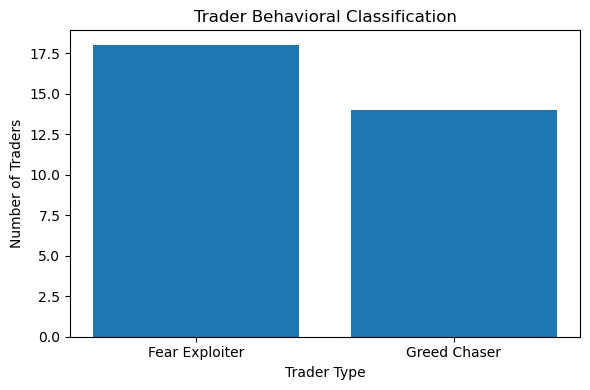

In [23]:
types = profile["trader_type"].value_counts()

plt.figure(figsize=(6,4))
plt.bar(types.index, types.values)
plt.title("Trader Behavioral Classification")
plt.xlabel("Trader Type")
plt.ylabel("Number of Traders")
plt.tight_layout()
plt.show()


# Fear vs Greed Profitability

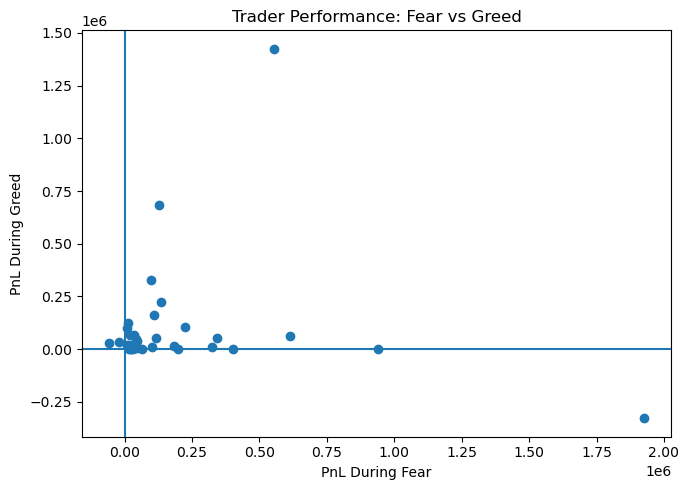

In [24]:
plt.figure(figsize=(7,5))
plt.scatter(profile["fear_edge"], profile["greed_edge"])
plt.axhline(0)
plt.axvline(0)
plt.xlabel("PnL During Fear")
plt.ylabel("PnL During Greed")
plt.title("Trader Performance: Fear vs Greed")
plt.tight_layout()
plt.show()


# Discipline Index (Risk Intelligence)

In [26]:
risk_behavior = (
    df.groupby("classification")["Size USD"]
    .mean()
    .reset_index()
)


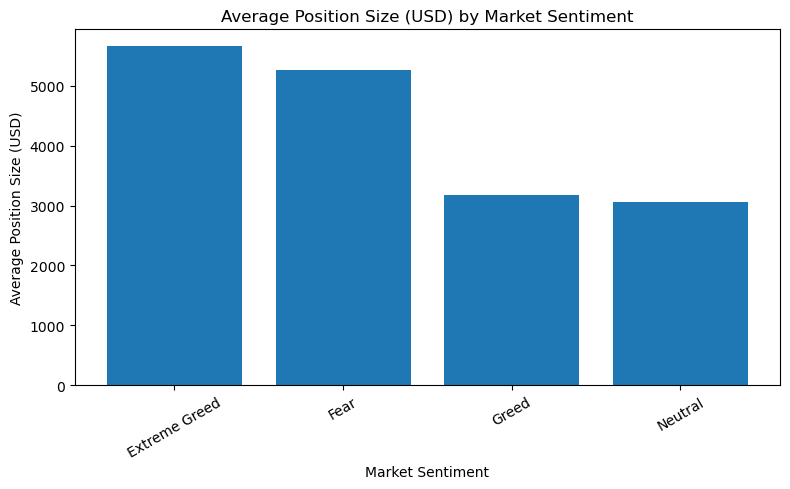

In [27]:
plt.figure(figsize=(8,5))
plt.bar(risk_behavior["classification"], risk_behavior["Size USD"])
plt.title("Average Position Size (USD) by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Position Size (USD)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Consistency Score (Risk-Adjusted Skill)

In [28]:
consistency = (
    df.groupby("Account")["Closed PnL"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

consistency["consistency_score"] = consistency["mean"] / (consistency["std"] + 1)


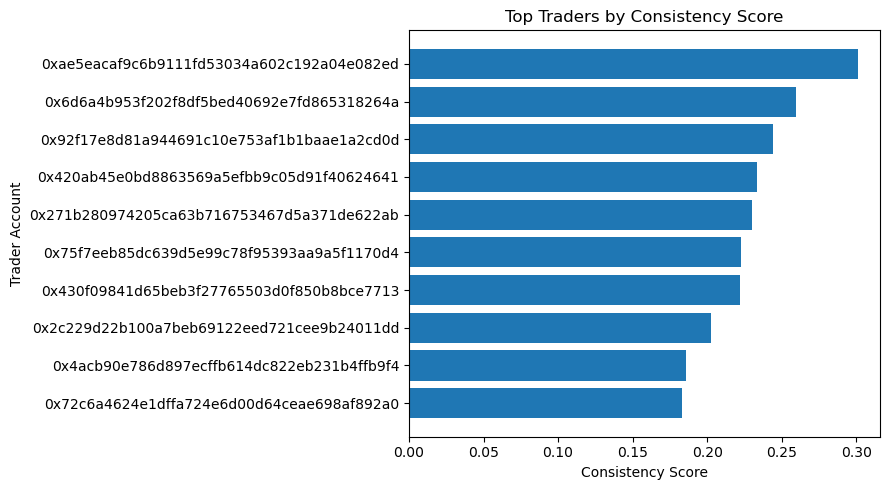

In [29]:
top_consistent = consistency.sort_values(
    "consistency_score", ascending=False
).head(10)

plt.figure(figsize=(9,5))
plt.barh(top_consistent["Account"], top_consistent["consistency_score"])
plt.title("Top Traders by Consistency Score")
plt.xlabel("Consistency Score")
plt.ylabel("Trader Account")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# Copy-Trading Strategy Simulation

In [30]:
top_fear_traders = (
    df[df["classification"].isin(["Fear", "Extreme Fear"])]
    .groupby("Account")["Closed PnL"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

copy_trading_pnl = (
    df[df["Account"].isin(top_fear_traders)]
    .groupby("date")["Closed PnL"]
    .sum()
)


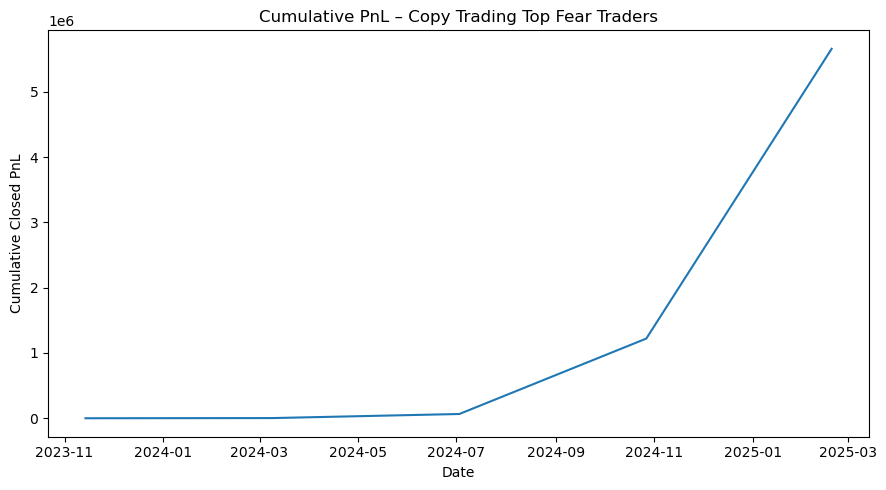

In [40]:
plt.figure(figsize=(9,5))
plt.plot(copy_trading_pnl.cumsum().index,
         copy_trading_pnl.cumsum().values)

plt.title("Cumulative PnL – Copy Trading Top Fear Traders")
plt.xlabel("Date")
plt.ylabel("Cumulative Closed PnL")
plt.tight_layout()
plt.show()
